In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

data_path = "/content/drive/MyDrive/colonoscopic/SNU_datasets/202303/datasets/"
print("The number of train examples: ", len(os.listdir(data_path)))

The number of train examples:  467


In [3]:
import cv2
import numpy as np

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(76)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    b, g, r = cv2.split(img)   # img파일을 b,g,r로 분리
    img2 = cv2.merge([r,g,b]) # b, r을 바꿔서 Merge
    plt.subplot(3,2,i)
    plt.imshow(img2)

In [ ]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


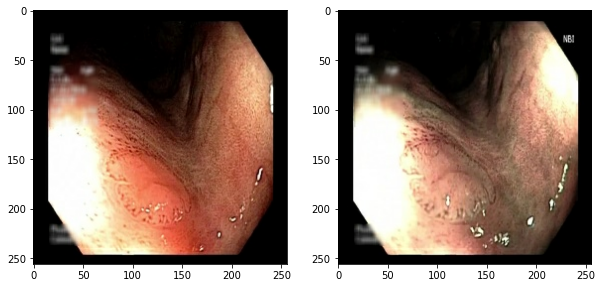

In [ ]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)

    w = tf.shape(img)[1] // 2
    nbi = img[:, :w, :]
    nbi = tf.cast(nbi, tf.float32)

    wl = img[:, w:, :]
    wl = tf.cast(wl, tf.float32)
    return normalize(wl), normalize(nbi)

f = data_path + os.listdir(data_path)[1]
wl, nbi = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(wl))
plt.subplot(1,2,2); plt.imshow(denormalize(nbi))

In [ ]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다.
def apply_augmentation(wl, nbi):
    stacked = tf.concat([wl, nbi], axis=-1)

    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])

    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)

    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)

    return out[...,:3], out[...,3:]

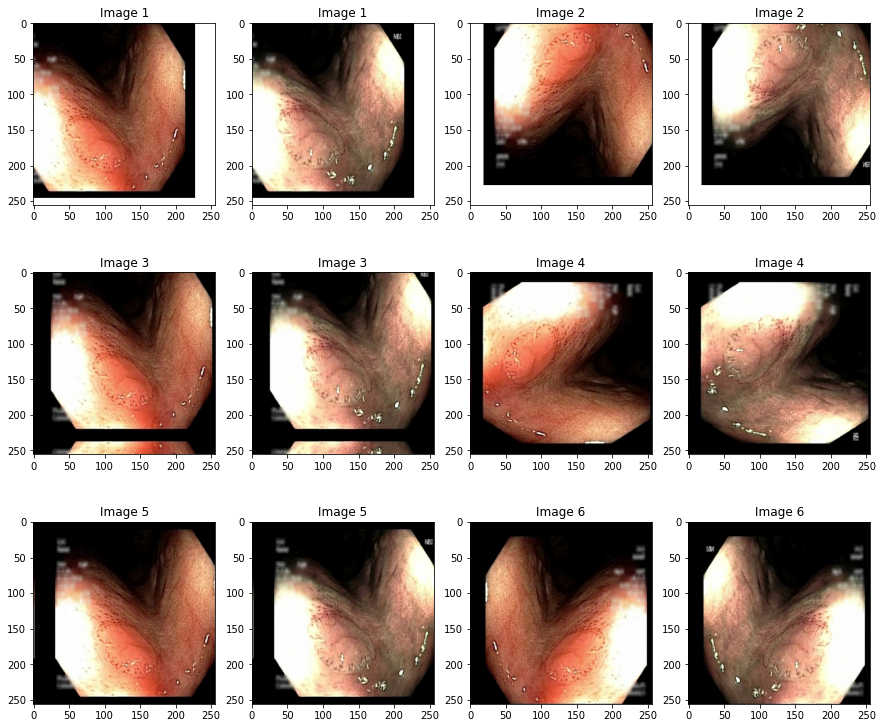

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_wl, augmented_nbi = apply_augmentation(wl, nbi)

    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_wl)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1);
    plt.imshow(denormalize(augmented_nbi)); plt.title(f"Image {img_n}")
    img_n += 1

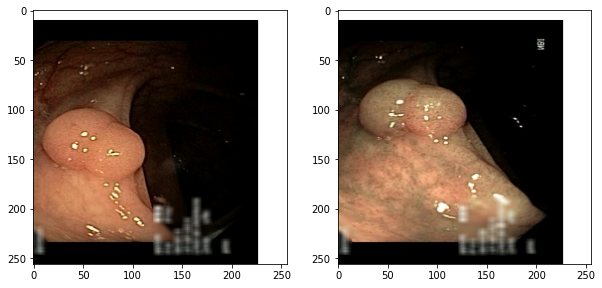

In [ ]:
from tensorflow import data

def get_train(img_path):
    wl, nbi = load_img(img_path)
    wl, nbi = apply_augmentation(wl, nbi)
    return wl, nbi

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(16)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
wl, nbi = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(wl[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(nbi[0].astype(np.uint8))

In [ ]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [ ]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]

        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x

    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBlock  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 encode_block_2 (EncodeBlock  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 encode_block_3 (EncodeBlock  (None, 16, 16, 512)      2099200   
 )                                                               
                                                             

In [ ]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)


class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]

        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))

        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x

    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block (DecodeBlock)  (None, 2, 2, 512)         4196352   
                                                                 
 decode_block_1 (DecodeBlock  (None, 4, 4, 512)        4196352   
 )                                                               
                                                                 
 decode_block_2 (DecodeBlock  (None, 8, 8, 512)        4196352   
 )                                                               
                                                                 
 decode_block_3 (DecodeBlock  (None, 16, 16, 512)      4196352   
 )                                                               
                                                           

In [ ]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder_1 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_1 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [ ]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]

        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))

        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))

        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)

    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)

        features = features[:-1]

        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])

        x = self.last_conv(x)
        return x

    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_16 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_17 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_16[0][0]']        
                                                                                            

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act

        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)

        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None

    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)

        if self.use_bn:
            x = self.batchnorm(x)

        if self.act:
            x = self.lrelu(x)
        return x

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")

        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))

    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)

    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape)
        return Model((x, y), self.call(x, y)).summary()

In [ ]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

In [ ]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [ ]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gene_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(wl, real_nbi):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_nbi = generator(wl, training=True)
        # Discriminator 예측
        fake_disc = discriminator(wl, fake_nbi, training=True)
        real_disc = discriminator(wl, real_nbi, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_nbi, real_nbi, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)

    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (wl, nbi) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(wl, nbi)

        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

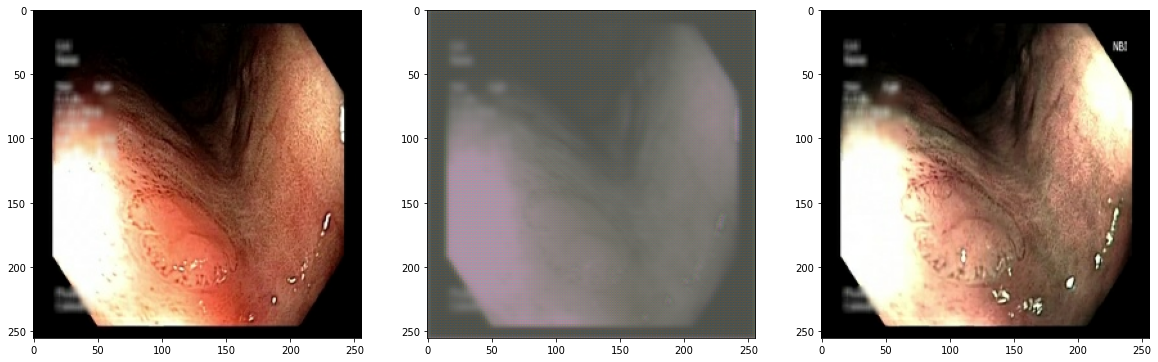

In [ ]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
wl, nbi = load_img(f)

pred = generator(tf.expand_dims(wl, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(wl))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(nbi))